In [4]:
!pip install ray

  Obtaining dependency information for ray from https://files.pythonhosted.org/packages/7b/9d/990621363be8b07597ef01b40283f7b03bd6386752997e6ede76096f9284/ray-2.7.1-cp310-cp310-macosx_11_0_arm64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 271.3 kB/s eta 0:00:0000:0100:07


In [28]:
import os
import ray
import yaml
import time 
import duckdb
import openai
import tiktoken
import pandas as pd
from pathlib import Path

In [58]:
with open('cadentials.yaml') as f:
    credentials = yaml.load(f, Loader=yaml.FullLoader)

os.environ['OPENAI_API_KEY'] = credentials['OPENAI_API_KEY']
os.environ['HUGGINGFACEHUB_API_TOKEN'] = credentials['HUGGINGFACEHUB_API_TOKEN']
os.environ['ENGINE'] = credentials['ENGINE']

openai.api_key = credentials['OPENAI_API_KEY']
openai.api_base = credentials['OPENAI_API_BASE']
openai.api_type = credentials['OPENAI_API_TYPE']
openai.api_version = credentials['OPENAI_API_VERSION']
openai.engine = credentials['ENGINE']

enc = tiktoken.encoding_for_model("gpt-3.5-turbo")

# 1 What is RAG ?

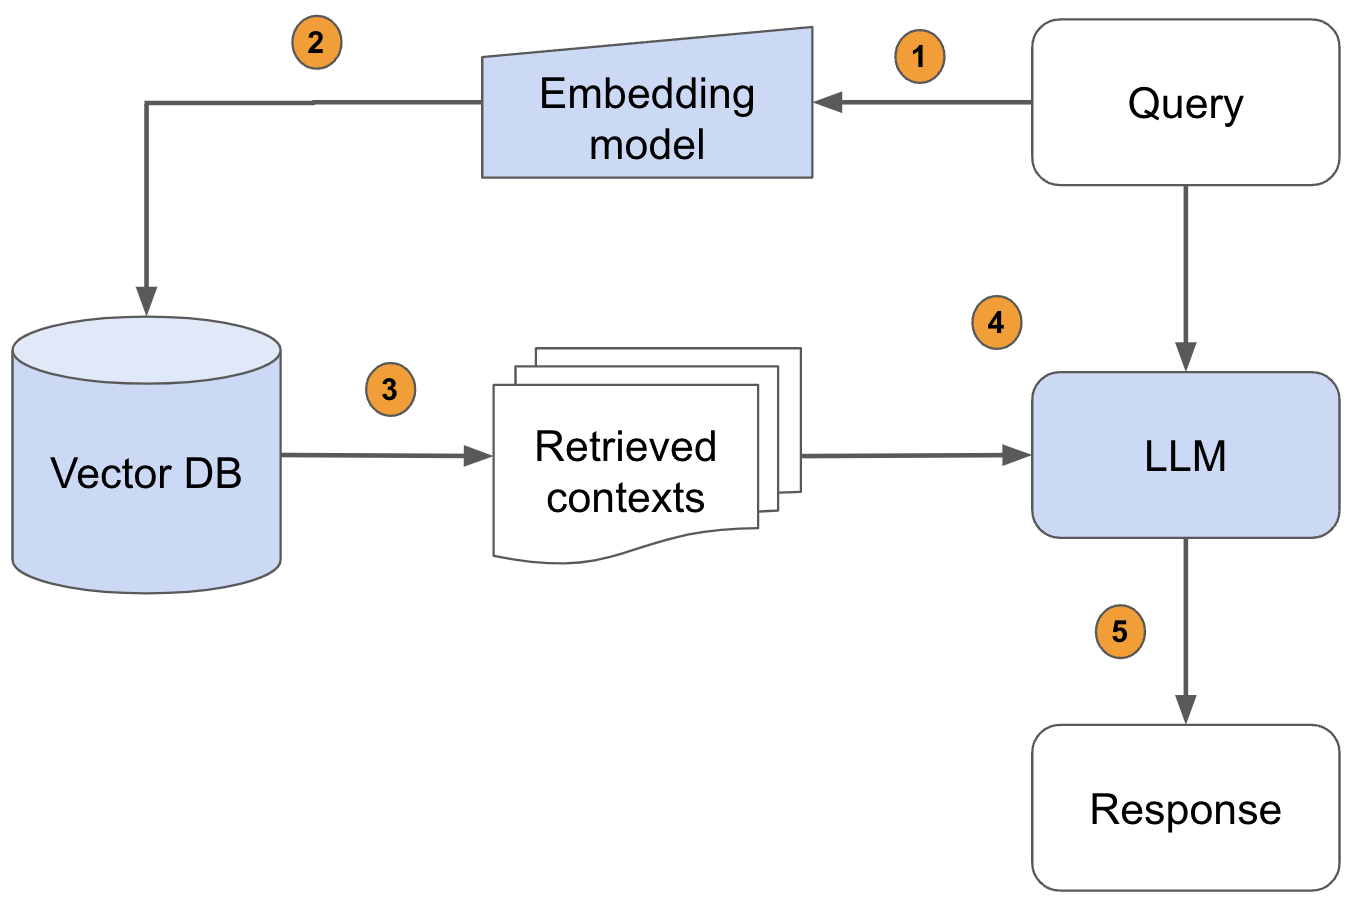

## Step 1: Loading and parsing the Data
##### This data processing pipeline has 3 steps:

    - First, we will load the latest documentation for Ray
    - Then we will parse the documentation to extract out chunks of text
    - Finally, we will embed each chunk. This creates a vector representation of the provided text snippet. This vector representation allows us to easily determine the similarity between two different text snippets.

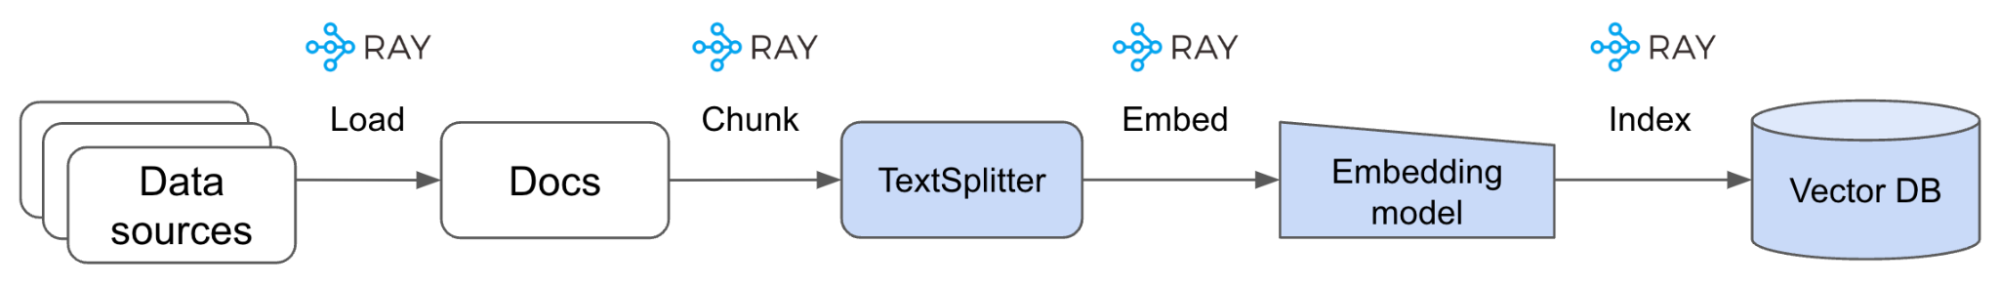

In [7]:
data_dir = 'datasets/rag_docs/en/master/'

In [8]:
docs_path = Path(data_dir)
ds = ray.data.from_items([{"path": path} for path in docs_path.rglob("*.html") if not path.is_dir()])
print(f"{ds.count()} documents")

3294 documents


In [9]:
from llama_index.readers import HTMLTagReader

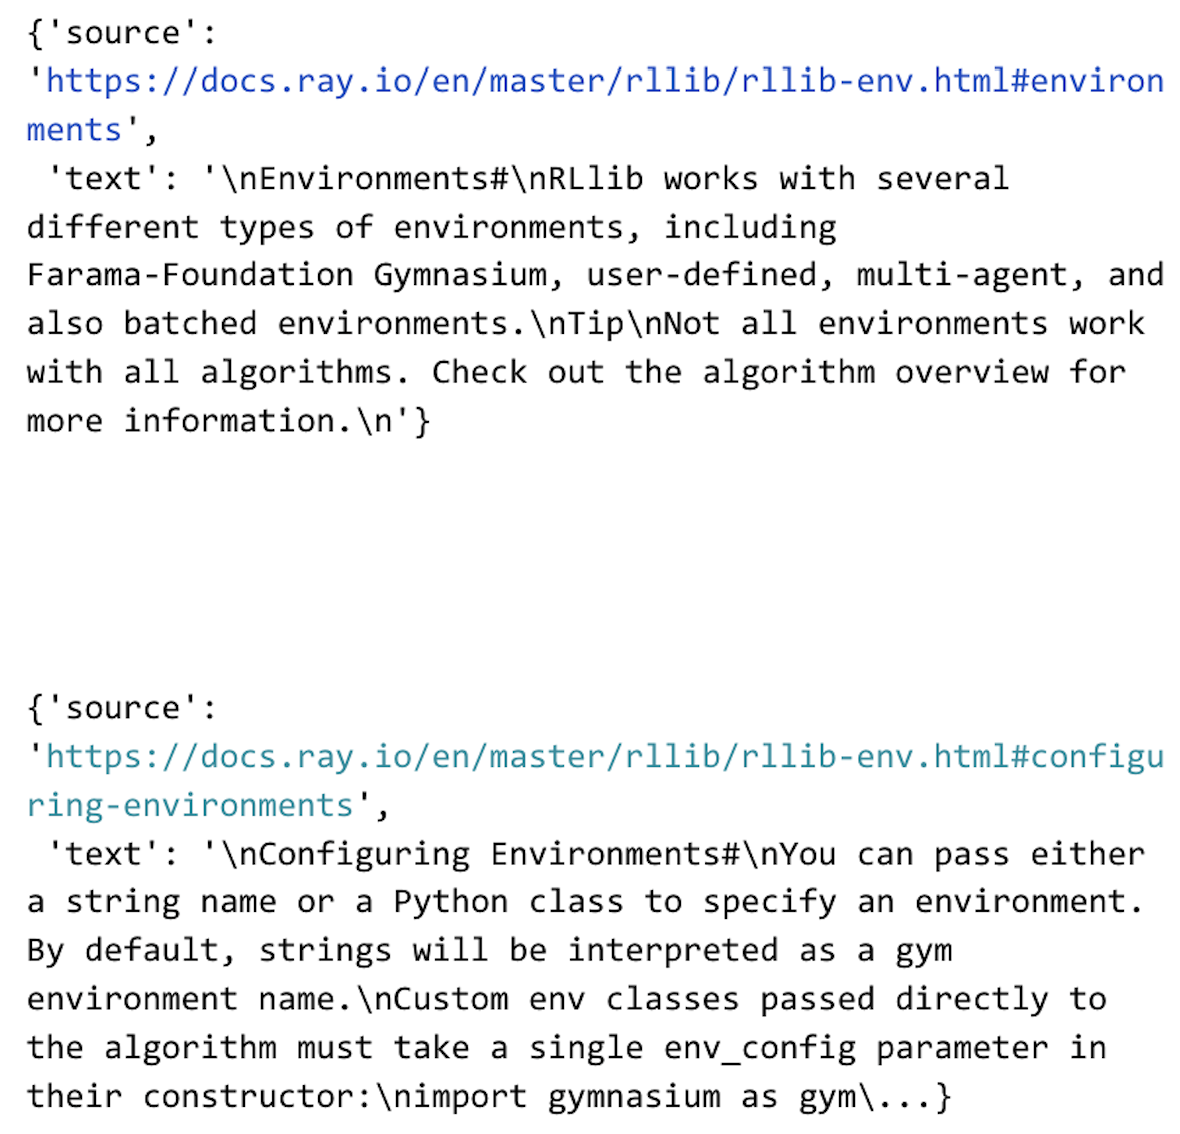

In [10]:
def path_to_uri(
                path, 
                scheme="https://", 
                domain="docs.ray.io"
                ):
    # Converts the file path of a Ray documentation page to the original URL for the documentation.
    # Example: /efs/shared_storage/goku/docs.ray.io/en/master/rllib-env.html -> https://docs.ray.io/en/master/rllib/rllib-env.html#environments
    return scheme + domain + str(path).split(domain)[-1]

def extract_sections(record):
    # Given a HTML file path, extract out text from the section tags, and return a LlamaIndex document from each one. 
    html_file_path = record["path"]
    reader = HTMLTagReader(tag="section")
    documents = reader.load_data(html_file_path)
    
    for document in documents:
        document.metadata["source"] = f"{path_to_uri(document.metadata['file_path'])}#{document.metadata['tag_id']}"
    return [{"document": document} for document in documents]

In [20]:
# retrieve a single document
example_path = Path(data_dir, "rllib/rllib-env.html")
document = extract_sections({"path": example_path})[0]["document"]
print(document)
print("\n")
print("Document source: ", document.metadata["source"])

Doc ID: 0c0b1065-0977-46bf-8e51-101dbf03ef69
Text: Environments# RLlib works with several different types of
environments, including Farama-Foundation Gymnasium, user-defined,
multi-agent, and also batched environments. Tip Not all environments
work with all algorithms. Check out the algorithm overview for more
information.


Document source:  https://docs.ray.iodatasets/rag_docs/en/master/rllib/rllib-env.html#environments


#### Apply the parser parallely

In [21]:
sections_ds = ds.flat_map(extract_sections)
sections_ds.schema()

2023-11-02 16:53:18,017	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)] -> LimitOperator[limit=1]
2023-11-02 16:53:18,017	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-11-02 16:53:18,018	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Column    Type
------    ----
document  <class 'object'>

##### Chunking

We now have a list of Documents (with text and source of each section) but we shouldn't directly use this as context to our RAG application just yet. The text lengths of each section are all varied and many are quite large chunks. If were to use these large sections, then we'd be inserting a lot of noisy/unwanted context and because all LLMs have a maximum context length, we wouldn't be able to fit too many relevant contexts. Therefore, we're going to split the text within each section into smaller chunks. Intuitively, smaller chunks will encapsulate single/few concepts and will be less noisy compared to larger chunks. We're going to choose some typical text splitting values (ex. chunk_size=512) to create our chunks for now but we'll be experiments with a range of values later.

In [65]:
def get_section_token_length(section_record):
    # Given a section record, return the length of the section text
    document = section_record["document"].text
    token_count = len(enc.encode(document))
    return token_count

In [68]:
token_distribution = []
for section_record in sections_ds.take(sections_ds.count()):
    token_distribution.append(get_section_token_length(section_record))

token_distribution_pd = pd.Series(token_distribution)
print(token_distribution_pd.describe())

2023-11-02 17:16:05,017	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)] -> LimitOperator[limit=5619]
2023-11-02 17:16:05,018	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-11-02 17:16:05,018	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

count     5619.000000
mean       296.315893
std        896.925506
min          2.000000
25%         53.000000
50%        114.000000
75%        267.000000
max      17551.000000
dtype: float64


/Users/1zuu/anaconda3/envs/llm/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/1zuu/anaconda3/envs/llm/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


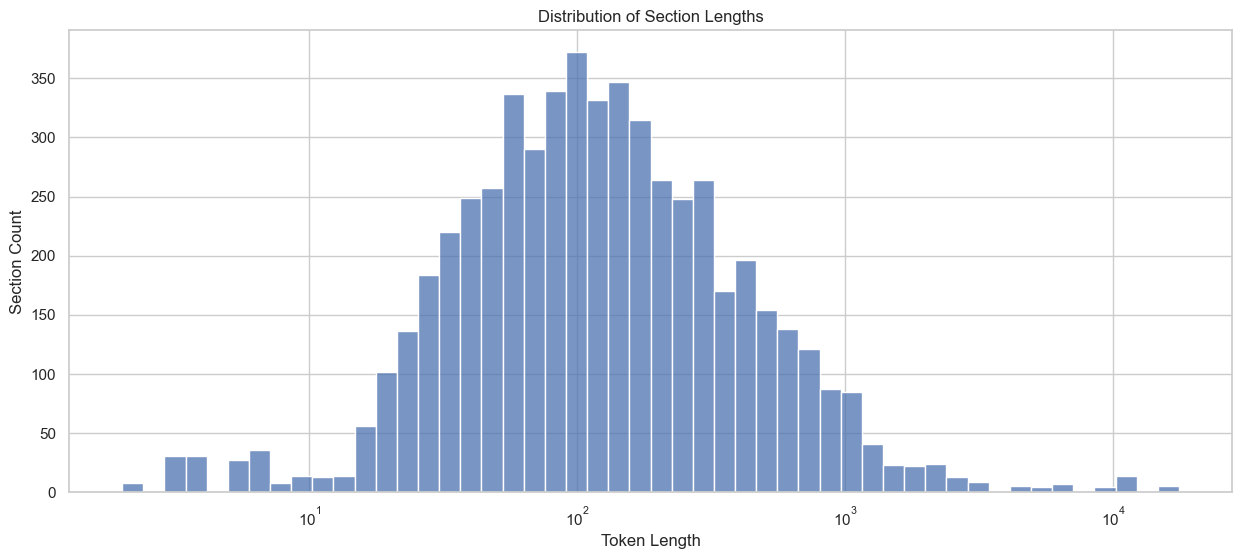

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
sns.set_theme(style="whitegrid")
sns.histplot(token_distribution_pd, log_scale=True)
plt.xlabel("Token Length")
plt.ylabel("Section Count")
plt.title("Distribution of Section Lengths")
plt.savefig("visualizations/production_rag/section_length_distribution.png")
plt.show()

In [72]:
from llama_index.node_parser import SimpleNodeParser

In [73]:
chunk_size = 512
chunk_overlap = 50

def chunk_document(document):
    node_parser = SimpleNodeParser.from_defaults(
                                                chunk_size=chunk_size,
                                                chunk_overlap=chunk_overlap
                                                )
    nodes = node_parser.get_nodes_from_documents([document["document"]])
    return [{"node": node} for node in nodes]

In [74]:
sample_document = sections_ds.take(1)[0]
nodes = chunk_document(sample_document)

print("Num chunks: ", len(nodes))
print(f"Example text: {nodes[0]['node'].text}\n")
print(f"Example metadata: {nodes[0]['node'].metadata}\n")

2023-11-02 17:20:17,510	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)] -> LimitOperator[limit=1]
2023-11-02 17:20:17,511	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-11-02 17:20:17,512	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/1zuu/Library/Caches/llama_index...


Num chunks:  1
Example text: ray.job_submission.JobInfo.entrypoint#
JobInfo.entrypoint: str#
The entrypoint command for this job.

Example metadata: {'tag': 'section', 'tag_id': 'ray-job-submission-jobinfo-entrypoint', 'file_path': 'datasets/rag_docs/en/master/cluster/running-applications/job-submission/doc/ray.job_submission.JobInfo.entrypoint.html', 'source': 'https://docs.ray.iodatasets/rag_docs/en/master/cluster/running-applications/job-submission/doc/ray.job_submission.JobInfo.entrypoint.html#ray-job-submission-jobinfo-entrypoint'}



[nltk_data]   Unzipping tokenizers/punkt.zip.


In [77]:
from ray.util.scheduling_strategies import NodeAffinitySchedulingStrategy

chunks_ds = sections_ds.flat_map(
                                chunk_document, 
                                scheduling_strategy=NodeAffinitySchedulingStrategy(
                                                                                    node_id=ray.get_runtime_context().get_node_id(), 
                                                                                    soft=False
                                                                                    )
                                )
chunks_ds.schema()

2023-11-02 17:23:32,899	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)] -> TaskPoolMapOperator[FlatMap(chunk_document)] -> LimitOperator[limit=1]
2023-11-02 17:23:32,900	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-11-02 17:23:32,901	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

Column  Type
------  ----
node    <class 'object'>

In [82]:
chunks_ds.take(3)

2023-11-02 17:26:22,750	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)] -> TaskPoolMapOperator[FlatMap(chunk_document)] -> LimitOperator[limit=3]
2023-11-02 17:26:22,750	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-11-02 17:26:22,751	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

[{'node': TextNode(id_='e1a38390-93e7-4950-8918-f2849ca16c96', embedding=None, metadata={'tag': 'section', 'tag_id': 'ray-job-submission-jobinfo-entrypoint', 'file_path': 'datasets/rag_docs/en/master/cluster/running-applications/job-submission/doc/ray.job_submission.JobInfo.entrypoint.html', 'source': 'https://docs.ray.iodatasets/rag_docs/en/master/cluster/running-applications/job-submission/doc/ray.job_submission.JobInfo.entrypoint.html#ray-job-submission-jobinfo-entrypoint'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='bb3b4369-e565-4db2-80eb-f6261abc7478', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'tag': 'section', 'tag_id': 'ray-job-submission-jobinfo-entrypoint', 'file_path': 'datasets/rag_docs/en/master/cluster/running-applications/job-submission/doc/ray.job_submission.JobInfo.entrypoint.html', 'source': 'https://docs.ray.iodatasets/rag_docs/en/master/cluster/running-applications/job

## Step 2 : Text Embedding Generation

In [78]:
import numpy as np
from llama_index.embeddings import OpenAIEmbedding, HuggingFaceEmbedding

def get_embedding_model(
                        model_name, 
                        embed_batch_size=100
                        ):
    if model_name == "text-embedding-ada-002":
            return OpenAIEmbedding(
                                model=model_name,
                                embed_batch_size=embed_batch_size,
                                api_key=os.environ["OPENAI_API_KEY"]
                                )
    else:
        return HuggingFaceEmbedding(
                                    model_name=model_name,
                                    embed_batch_size=embed_batch_size
                                    )

In [83]:
class EmbedChunks:
    def __init__(self, model_name):
        self.embedding_model = get_embedding_model(model_name)
    
    def __call__(self, node_batch):
        # Get the batch of text that we want to embed.
        nodes = node_batch["node"]
        text = [node.text for node in nodes]
        
        # Embed the batch of text.
        embeddings = self.embedding_model.get_text_embedding_batch(text)
        assert len(nodes) == len(embeddings)

        # Store the embedding in the LlamaIndex node.
        for node, embedding in zip(nodes, embeddings):
            node.embedding = embedding
        return {"embedded_nodes": nodes}

In [86]:
embedding_model_name = "thenlper/gte-base"
embedder = EmbedChunks(model_name=embedding_model_name)

/Users/1zuu/anaconda3/envs/llm/lib/python3.10/site-packages/bitsandbytes/cextension.py:34: UserWarning: The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.
  warn("The installed version of bitsandbytes was compiled without GPU support. "


'NoneType' object has no attribute 'cadam32bit_grad_fp32'


In [87]:
# let's embed the first batch
example_chunk = chunks_ds.take_batch(1)
example_node_with_embedding = embedder(example_chunk)
example_node_with_embedding

2023-11-02 17:33:42,799	INFO streaming_executor.py:93 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[FlatMap(extract_sections)] -> TaskPoolMapOperator[FlatMap(chunk_document)] -> LimitOperator[limit=1]
2023-11-02 17:33:42,800	INFO streaming_executor.py:94 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-11-02 17:33:42,801	INFO streaming_executor.py:96 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`


Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

{'embedded_nodes': array([TextNode(id_='8d727563-069a-4208-b0df-d43b33057943', embedding=[0.012151701375842094, 0.009003259241580963, 0.04299211502075195, 0.020694075152277946, 0.04641931876540184, 0.028719110414385796, 0.03518187627196312, 0.04549027234315872, -0.009504409506917, -0.059506602585315704, -0.0038274729158729315, 0.01912284642457962, -0.0585508868098259, 0.04618799313902855, 0.02355988882482052, 0.07821550965309143, 0.034895315766334534, -0.006222483702003956, -0.01033514179289341, 0.025893379002809525, -0.008063158020377159, 0.012081233784556389, -0.0055470713414251804, 0.03640363737940788, 0.013457839377224445, -0.052092503756284714, -0.0017167986370623112, 0.014058866538107395, -0.04195301979780197, -0.01892777718603611, 0.019436266273260117, -0.020999927073717117, -0.009712929837405682, -0.046159062534570694, -0.016599424183368683, 0.011881574057042599, 0.007980303838849068, -0.0056480541825294495, -0.029521433636546135, -0.04047169163823128, -0.013158640824258327, 0.

In [89]:
print(example_node_with_embedding["embedded_nodes"][0])
print("\n")
print("Embedding size: ", len(example_node_with_embedding["embedded_nodes"][0].embedding))

Node ID: 8d727563-069a-4208-b0df-d43b33057943
Text: Ray Jobs Overview# Once you have deployed a Ray cluster (on VMs
or Kubernetes), you are ready to run a Ray application!


Embedding size:  768


In [96]:
import faiss
from ray.data import ActorPoolStrategy

embedded_chunks = chunks_ds.map_batches(
                                        EmbedChunks,
                                        fn_constructor_kwargs={"model_name": embedding_model_name},
                                        batch_size=100, 
                                        num_gpus=1,
                                        compute=ActorPoolStrategy(size=2)
                                        )

In [97]:
from llama_index import VectorStoreIndex
from llama_index import (
                        SimpleDirectoryReader,
                        load_index_from_storage,
                        VectorStoreIndex,
                        StorageContext,
                        )
from llama_index.vector_stores.faiss import FaissVectorStore

In [101]:
d = 768
faiss_index = faiss.IndexFlatL2(d)

vector_store = FaissVectorStore(faiss_index=faiss_index)
storage_context = StorageContext.from_defaults(vector_store=vector_store)
index = VectorStoreIndex.from_documents(storage_context)

index.add_documents(embedded_chunks)